In [1]:
# Loading vital packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
# from datetime import datetime

sb.set_theme()

In [2]:
# Loading the dataset into pandas dataframe

df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Some Exploratory Data Analysis

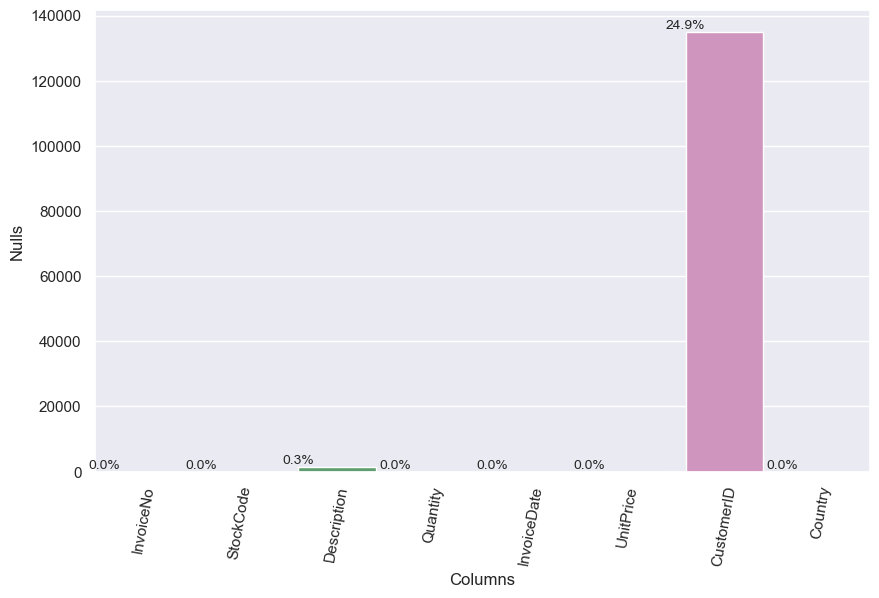

In [5]:
# Visualizing the missing values throughout the entire corpus

x = df.columns
y = df.isnull().sum()
plt.figure(figsize=(10, 6))
sb.set()
sb.barplot(x=x, y=y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/df.shape[0], 3))+"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("Nulls")
plt.xticks(rotation=80)
plt.show()

In [6]:
# Checking for the length of time in which this dataset was gathered

time_interval = df['InvoiceDate'].max() - df['InvoiceDate'].min()
print(f'The time interval of this inventory is {time_interval.days} days')

The time interval of this inventory is 373 days


In [7]:
# Out of curiosity, checking for values equal to or less than 0 in the Quantity column

df[df['Quantity'] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


Over 10000 rows have 0 or negative values in the Quantity column. This does not make any logical sense. I think it is better that all these columns be dropped from further processing for the recommender engine.

In [8]:
df.drop(df[df['Quantity'] <= 0].index, inplace=True)
df['Quantity'].value_counts()

Quantity
1        148227
2         81829
12        61063
6         40868
4         38484
          ...  
828           1
512           1
3100          1
291           1
80995         1
Name: count, Length: 393, dtype: int64

In [9]:
# Checking for the most expensive items

df.sort_values(by='UnitPrice', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
297723,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,NaN,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
258274,559603,79337,NaN,1,2011-07-11 11:27:00,0.00,NaN,United Kingdom
258273,559602,84686,NaN,23,2011-07-11 11:26:00,0.00,NaN,United Kingdom
21777,538128,21357,NaN,46,2010-12-09 15:54:00,0.00,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom


Some unusual instances where UnitPrice values is less than 0 is also observed. The next step is to drop all UnitPrice values that are equal to or less than 0. A customer cannot buy an item if its price is 0. Some missing values can also be observed for the CustomerID column.

In [10]:
df.drop(df[df['UnitPrice'] <= 0].index, inplace=True)

In [11]:
# Checking for the total number of missing values in the CustomerID column

df['CustomerID'].isnull().sum()

132220

It is quite interesting to observe that over 130000 entries are missing from this dataset. I will look further to find any interesting trend in the dataset for this specific condition.

In [12]:
# df[df['CustomerID'].isnull()].head(50)
# df[df['CustomerID'].isnull()].tail(50)
df[df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


The most likely conclusion/observation I can come up with is that was probably some sort of glitch in the technology used to capture these entries having missing values in the CustomerID column.

In [13]:
df.drop(df[df['CustomerID'].isnull()].index, inplace=True)

In [14]:
# Checking for missing values in the Description column

df[df['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [16]:
df.nunique()

InvoiceNo      18532
StockCode       3665
Description     3877
Quantity         301
InvoiceDate    17282
UnitPrice        440
CustomerID      4338
Country           37
dtype: int64

In [17]:
# Checking for unique items across the columns
for col in df.columns:
    uq = df[col].nunique()
    print(f'The {col} column has {round(uq/len(df)*100, 2)}% of unique items')

The InvoiceNo column has 4.66% of unique items
The StockCode column has 0.92% of unique items
The Description column has 0.97% of unique items
The Quantity column has 0.08% of unique items
The InvoiceDate column has 4.34% of unique items
The UnitPrice column has 0.11% of unique items
The CustomerID column has 1.09% of unique items
The Country column has 0.01% of unique items


In [18]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [19]:
# Checking for duplicates in the dataset

for col in df.columns:
    duplicates = df[col].duplicated().sum()
    print(f'The {col} column has {round(duplicates/len(df)*100, 2)}% duplicates')

The InvoiceNo column has 95.34% duplicates
The StockCode column has 99.08% duplicates
The Description column has 99.03% duplicates
The Quantity column has 99.92% duplicates
The InvoiceDate column has 95.66% duplicates
The UnitPrice column has 99.89% duplicates
The CustomerID column has 98.91% duplicates
The Country column has 99.99% duplicates


In [20]:
df.duplicated().sum()

5192

## Modeling Process

In [21]:
# Dropping null values for both columns because since we are going to index the CustomerIDs, it makes no sense keeping the missing CustomerIDs

df['Description'] = df['Description'].dropna(axis=0)
df.reset_index(drop=True, inplace=True)

In [22]:
# Using the CustomerID to group the original dataframe by collecting all items bought by each customer

dataframe = df.groupby('CustomerID')['StockCode'].apply(list).reset_index(name='Text')
dataframe.head()

,CustomerID,Text
0,12346.0,[23166]
1,12347.0,"[85116, 22375, 71477, 22492, 22771, 22772, 227..."
2,12348.0,"[84992, 22951, 84991, 84991, 21213, 21213, 226..."
3,12349.0,"[23112, 23460, 21564, 21411, 21563, 22131, 221..."
4,12350.0,"[21908, 22412, 79066K, 79191C, 22348, 84086C, ..."


In [23]:
# Preprocessing the Text column

dataframe['Text'] = [', '.join(map(str, x)) for x in dataframe['Text']]
# dataframe['Processed_Text'] = [', '.join(map(str, x)) for x in dataframe['Text']]
dataframe.head()

,CustomerID,Text
0,12346.0,23166
1,12347.0,"85116, 22375, 71477, 22492, 22771, 22772, 2277..."
2,12348.0,"84992, 22951, 84991, 84991, 21213, 21213, 2261..."
3,12349.0,"23112, 23460, 21564, 21411, 21563, 22131, 2219..."
4,12350.0,"21908, 22412, 79066K, 79191C, 22348, 84086C, 2..."


In [24]:
# Checking for the highest and lowest number of products bought by a single customer

max_items = dataframe['Text'].apply(lambda x: x.split(', ')).str.len().max()
min_items = dataframe['Text'].apply(lambda x: x.split(', ')).str.len().min()
print(f'The highest number of items bought by a customer is {max_items}')
print(f'The lowest number of items bought by a customer is {min_items}')

The highest number of items bought by a customer is 7847
The lowest number of items bought by a customer is 1


In [25]:
# Investigating further to identify the customer who bought this much items

dataframe.loc[dataframe['Text'].apply(lambda x: len(x.split(', '))).idxmax()]

CustomerID                                              17841.0
Text          21495, 46000R, 46000S, 22731, 21258, 21041, 84...
Name: 4010, dtype: object

In [26]:
# Looking into the customer who bought more than 7000 products over the space of approximately one year

df[df['CustomerID'] == 17841.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1473,536557,21495,SKULLS AND CROSSBONES WRAP,25,2010-12-01 14:41:00,0.42,17841.0,United Kingdom
1474,536557,46000R,POLYESTER FILLER PAD 45x30cm,2,2010-12-01 14:41:00,1.45,17841.0,United Kingdom
1475,536557,46000S,POLYESTER FILLER PAD 40x40cm,1,2010-12-01 14:41:00,1.45,17841.0,United Kingdom
1476,536557,22731,3D CHRISTMAS STAMPS STICKERS,1,2010-12-01 14:41:00,1.25,17841.0,United Kingdom
1477,536557,21258,VICTORIAN SEWING BOX LARGE,1,2010-12-01 14:41:00,12.75,17841.0,United Kingdom
...,...,...,...,...,...,...,...,...
395423,581334,23399,HOME SWEET HOME HANGING HEART,3,2011-12-08 12:07:00,0.85,17841.0,United Kingdom
395424,581334,22893,MINI CAKE STAND T-LIGHT HOLDER,12,2011-12-08 12:07:00,0.42,17841.0,United Kingdom
395425,581334,22371,AIRLINE BAG VINTAGE TOKYO 78,1,2011-12-08 12:07:00,4.25,17841.0,United Kingdom
395426,581334,22309,TEA COSY RED STRIPE,1,2011-12-08 12:07:00,2.55,17841.0,United Kingdom


In [27]:
# Digging further to find out if the numbers regarding the number of products bought by this customer is realistic and not an error from the capturing device

df[df['CustomerID'] == 17841.0].groupby('InvoiceDate').agg({
    'Quantity': 'sum',
    'UnitPrice': 'sum',
    'StockCode': 'count'
    })

,Quantity,UnitPrice,StockCode
InvoiceDate,,,
2010-12-01 14:41:00,199,251.69,65
2010-12-03 14:35:00,136,107.35,29
2010-12-06 14:51:00,132,205.84,46
2010-12-09 17:27:00,116,150.05,46
2010-12-14 14:40:00,318,231.35,67
...,...,...,...
2011-11-29 17:52:00,357,401.57,158
2011-12-01 19:42:00,336,326.70,125
2011-12-02 13:49:00,52,73.90,29


As much as this sounds intriguing to me, I will probably conclude that this customer is most likely a business owner that buys items in order to resell them for profits. Or the customer has a small store.

In [28]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Text        4338 non-null   object 
dtypes: float64(1), object(1)
memory usage: 67.9+ KB


In [29]:
# Splitting the dataframe for passing into the vectorizer and then for calculating cosine similarity scores

data_train, data_test = train_test_split(dataframe, test_size=0.1, random_state=42)
data_train.shape, data_test.shape

((3904, 2), (434, 2))

In [30]:
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [31]:
# Define a Count Vectorizer object and remove all english stop words
cv = CountVectorizer(stop_words='english', lowercase=True)

# Construct the required vectorized matrix by fitting and transforming the first 15000 rows due to memory constraints
cv_train_matrix = cv.fit_transform(data_train['Text'])
cv_test_matrix = cv.transform(data_test['Text'])

In [32]:
# Calculating the similarity between the processed dataset

cosine_sim = cosine_similarity(cv_train_matrix, cv_test_matrix)
cosine_sim.shape

(3904, 434)

In [33]:
# Function to recommend top 5 products for a given CustomerID based on first purchase

def recommendations(customer_id, cosine_sim=cosine_sim, df=dataframe, original_df=df):
    
    # Get the index of the customer in the dataframe
    idx = df[df['CustomerID']==customer_id].index[0]
    
    # Calculate cosine similarity scores
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending=False)
    
    i = 0
    for item in score_series.index:
        product_desc = original_df['Description'][item]
        print(i+1, product_desc)
        i = i+1
        if i > 4:
            break

In [34]:
# Recommending top 5 products for the selected customers from the test set

recommendations(data_test.iloc[1]['CustomerID'])

1 PARTY CONES CANDY ASSORTED
2 CHOCOLATE HOT WATER BOTTLE
3 RED WOOLLY HOTTIE WHITE HEART.
4 POPPY'S PLAYHOUSE KITCHEN
5 DOORMAT FANCY FONT HOME SWEET HOME


These are the recommendations made by the engine based on the first purchase of the second customer on the testing set. I will try to probe further to validate the closeness of these recommendations to previous purchases made by the said customer.

In [35]:
# Tracing the purchases of the customer back to the original dataframe

df[df['CustomerID'] == data_test.iloc[1]['CustomerID']]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
32241,540692,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2011-01-11 09:12:00,1.25,14320.0,United Kingdom
32242,540692,22561,WOODEN SCHOOL COLOURING SET,12,2011-01-11 09:12:00,1.65,14320.0,United Kingdom
32243,540692,21125,SET 6 FOOTBALL CELEBRATION CANDLES,12,2011-01-11 09:12:00,1.25,14320.0,United Kingdom
32244,540692,21126,SET OF 6 GIRLS CELEBRATION CANDLES,12,2011-01-11 09:12:00,1.25,14320.0,United Kingdom
32245,540692,21733,RED HANGING HEART T-LIGHT HOLDER,6,2011-01-11 09:12:00,2.95,14320.0,United Kingdom
32246,540692,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-01-11 09:12:00,2.95,14320.0,United Kingdom
32247,540692,21175,GIN + TONIC DIET METAL SIGN,12,2011-01-11 09:12:00,2.10,14320.0,United Kingdom
32248,540692,21470,FLOWER VINE RAFFIA FOOD COVER,6,2011-01-11 09:12:00,3.75,14320.0,United Kingdom
32249,540692,21210,SET OF 72 RETROSPOT PAPER DOILIES,12,2011-01-11 09:12:00,1.45,14320.0,United Kingdom
32250,540692,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,2011-01-11 09:12:00,1.45,14320.0,United Kingdom


There seems to be some connections between the previous purchases of the customer and the recommendations from the engine. I will check the recommendations for another random customer from the testing set.

In [36]:
# Recommending top 5 products for the selected customers from the test set

recommendations(data_test.iloc[100]['CustomerID'])

1 WHITE SPOT RED CERAMIC DRAWER KNOB
2 FELTCRAFT PRINCESS CHARLOTTE DOLL
3 SCOTTIE DOG HOT WATER BOTTLE
4 PINK OVAL JEWELLED MIRROR
5 72 SWEETHEART FAIRY CAKE CASES


In [37]:
# Tracing the purchases of the customer back to the original dataframe

df[df['CustomerID'] == data_test.iloc[100]['CustomerID']].head(30)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4646,536983,22331,WOODLAND PARTY BAG + STICKER SET,8,2010-12-03 14:30:00,1.65,12712.0,Germany
4647,536983,22865,HAND WARMER OWL DESIGN,12,2010-12-03 14:30:00,2.10,12712.0,Germany
4648,536983,22171,3 HOOK PHOTO SHELF ANTIQUE WHITE,4,2010-12-03 14:30:00,8.50,12712.0,Germany
4649,536983,22926,IVORY GIANT GARDEN THERMOMETER,4,2010-12-03 14:30:00,5.95,12712.0,Germany
4650,536983,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-03 14:30:00,4.95,12712.0,Germany
4651,536983,84849D,HOT BATHS SOAP HOLDER,12,2010-12-03 14:30:00,1.69,12712.0,Germany
4652,536983,22445,PENCIL CASE LIFE IS BEAUTIFUL,6,2010-12-03 14:30:00,2.95,12712.0,Germany
4653,536983,16016,LARGE CHINESE STYLE SCISSOR,10,2010-12-03 14:30:00,0.85,12712.0,Germany
4654,536983,POST,POSTAGE,1,2010-12-03 14:30:00,18.00,12712.0,Germany
13103,537995,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,8,2010-12-09 11:39:00,2.95,12712.0,Germany


The recommendations from the engine seems to be in line with previous purchases of both random customers from the testing set.